<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DATA" data-toc-modified-id="DATA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DATA</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Target" data-toc-modified-id="Target-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Target</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model evaluation</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random Forest</a></span><ul class="toc-item"><li><span><a href="#Baseline-with-Numerical-Data" data-toc-modified-id="Baseline-with-Numerical-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Baseline with Numerical Data</a></span><ul class="toc-item"><li><span><a href="#pageDepth-+-sessionCount-+-daysSinceLastLession" data-toc-modified-id="pageDepth-+-sessionCount-+-daysSinceLastLession-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>pageDepth + sessionCount + daysSinceLastLession</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from scipy import stats
import statsmodels.api as sm
import os

## DATA

### Dataset

In [2]:
data_root="../data/"
datafile=os.path.join(data_root,'dfjoin_Scount_daysSLS_srceMed_city_device_OS_2019_2020_jan21.csv')
df=pd.read_csv(datafile)
print(df.shape)
df.head(3)

/home/dsc/TFM/kschool_masterDS_TFM/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(3936941, 15)


,Unnamed: 0,ga:productSKU,ga:dateHourMinute,ga:pagePath,ga:pageDepth,ga:sessionCount,ga:daysSinceLastSession,ga:sourceMedium,ga:city,ga:deviceCategory,ga:operatingSystem,ga:productListViews,ga:productListClicks,ga:productDetailViews,ga:productAddsToCart
0,0,1008,201904301452,/parafarmacia/es/,1,1,0,(direct) / (none),Burgos,mobile,iOS,1,0,0,0
1,1,1008,201904301524,/parafarmacia/es/,3,1,0,(direct) / (none),Madrid,desktop,Windows,1,0,0,0
2,2,1008,201904301545,/parafarmacia/es/,7,33,0,merchants.google.com / referral,Zamudio,desktop,Windows,1,0,0,0


In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)
print(df.shape)
print("")
df.info()

(3936941, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936941 entries, 0 to 3936940
Data columns (total 14 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   ga:productSKU            object
 1   ga:dateHourMinute        int64 
 2   ga:pagePath              object
 3   ga:pageDepth             int64 
 4   ga:sessionCount          int64 
 5   ga:daysSinceLastSession  int64 
 6   ga:sourceMedium          object
 7   ga:city                  object
 8   ga:deviceCategory        object
 9   ga:operatingSystem       object
 10  ga:productListViews      int64 
 11  ga:productListClicks     int64 
 12  ga:productDetailViews    int64 
 13  ga:productAddsToCart     int64 
dtypes: int64(8), object(6)
memory usage: 420.5+ MB


### Target

In [4]:
df['ga:productAddsToCart_transf']=df["ga:productAddsToCart"].apply(lambda x: 1 if x>1 else x)

print("No. observations per class")
print(df['ga:productAddsToCart_transf'].value_counts())
print("")

print("% observations per class")
print(100*df['ga:productAddsToCart_transf'].value_counts(normalize=True))

No. observations per class
0    3864256
1      72685
Name: ga:productAddsToCart_transf, dtype: int64

% observations per class
0    98.15377
1     1.84623
Name: ga:productAddsToCart_transf, dtype: float64


## Functions

### Model evaluation

In [5]:
def evaluate(classifier,features,target):
    X_train, X_test, y_train, y_test = train_test_split(features, target,random_state=42)
    classifier.fit(X_train,y_train)
    predictions = classifier.predict(X_test)
    probabilities = classifier.predict_proba(X_test)
    print("TRAINING SCORE: " + str(classifier.score(X_train,y_train)))
    print("ACCURACY: " + str(accuracy_score(y_test, predictions)))
    print("PRECISION: " + str(precision_score(y_test, predictions)))
    print("RECALL: " + str(recall_score(y_test, predictions)))
    print("F1 SCORE: " + str(f1_score(y_test, predictions)))
    print("AUC: " + str(roc_auc_score(y_test,probabilities[:, 1])))

    tpr, fpr, thresolds = roc_curve(y_test, probabilities[:, 1])
    plt.plot(tpr, fpr)
    plt.xlabel('fpr')
    plt.ylabel('tpr')

## Random Forest

### Baseline with Numerical Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936941 entries, 0 to 3936940
Data columns (total 15 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   ga:productSKU                object
 1   ga:dateHourMinute            int64 
 2   ga:pagePath                  object
 3   ga:pageDepth                 int64 
 4   ga:sessionCount              int64 
 5   ga:daysSinceLastSession      int64 
 6   ga:sourceMedium              object
 7   ga:city                      object
 8   ga:deviceCategory            object
 9   ga:operatingSystem           object
 10  ga:productListViews          int64 
 11  ga:productListClicks         int64 
 12  ga:productDetailViews        int64 
 13  ga:productAddsToCart         int64 
 14  ga:productAddsToCart_transf  int64 
dtypes: int64(9), object(6)
memory usage: 450.5+ MB


#### pageDepth + sessionCount + daysSinceLastLession

In [10]:
y=df['ga:productAddsToCart_transf']
X=df[['ga:pageDepth','ga:sessionCount','ga:daysSinceLastSession']]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

TRAINING SCORE: 0.9817191355045628
ACCURACY: 0.9813591455707777
PRECISION: 0.34663341645885287
RECALL: 0.007627304653204566
F1 SCORE: 0.014926174496644296
AUC: 0.6713505663241243


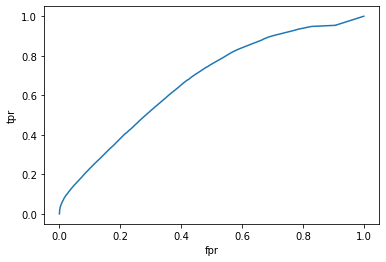

In [8]:
from sklearn.ensemble import RandomForestClassifier
clfr=RandomForestClassifier()
evaluate(clfr,X,y)

In [9]:
print(classification_report(y_test,clfr.predict(X_test)))
clfr_cm = confusion_matrix(y_test,clfr.predict(X_test))
clfr_cm

NameError: name 'y_test' is not defined